## Analyze floorplan's structure with Jupyter Notebook

Jupyter Notebook is a nice tool for data analysis since it can bind analysis, code, and result together with interactive process. However, floor plan analysis has been done in a seprate software such as depthmap and it could not utilize the power of interactive process. In this notebook, I'd like to demonstrate how we can analyze a floor plan's network structure with Jupyter Notebook.

We are going to use GeoPandas to manage spatial data and NetworkX to calculate network properties. 

In [1]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

import warnings
warnings.filterwarnings('ignore')

### Dataset

We will import floorplan data from esri's FileGDB. You can use any type of spatial data supported by OGR driver such as shp, dxf, and dwg. In this notebook, the key data set is room polygons. In our dataset, we created room boundary polygons for all rooms including circulation spaces. Other lines are just graphics irrelevant from actual analysis.

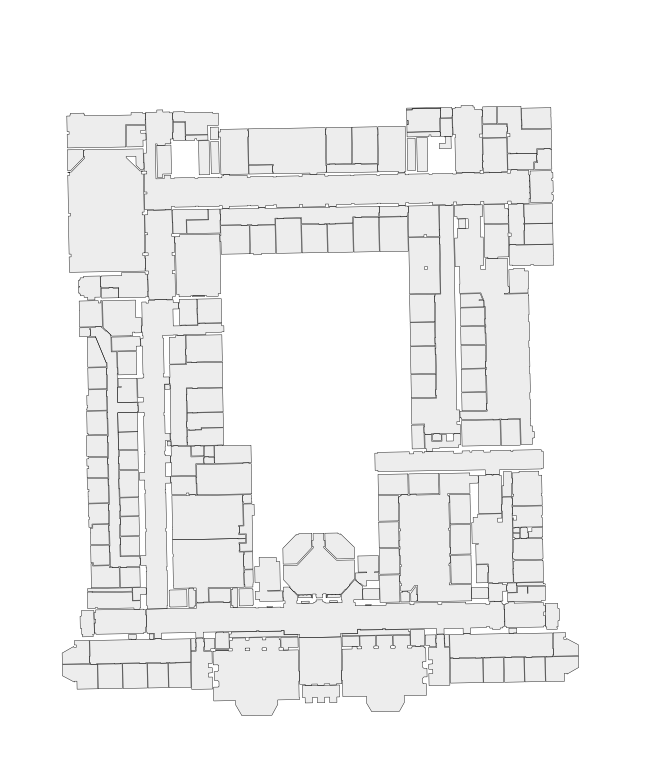

In [140]:
# read room polygons from esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  # room polygon is the second layer in our gdb

# let's look at them

from matplotlib import rcParams  
rcParams['figure.figsize'] = (9, 9) 

def default_ax():
    fig, ax = plt.subplots()
    ax.axison = False
    ax.set_aspect('equal')
    return ax

rooms.plot(ax=default_ax(), linewidth=0.3, color='#DDDDDD')
plt.show()

### Original floorplan

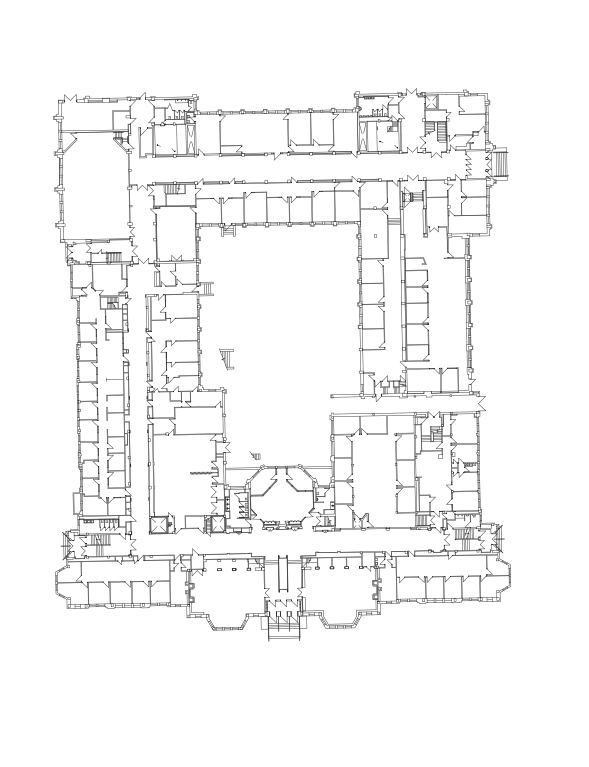

In [76]:
graphics = gpd.read_file(gdb_path, layer=3)  # third layer in the gdb
graphics.plot(ax=default_ax(), linewidth=0.3, color='k')
plt.show()

### Administrative information on rooms

In [137]:
# Luckily we have a table with information such as department and room type.
rooms_info = pd.read_csv("rooms_0221_01.csv")
rooms_info.RmRecNbr = rooms_info.RmRecNbr.apply(str)

# Let's join this table with the floorplan by rmrecnbr, which is a room unique id.
rooms = rooms.merge(rooms_info, how='left', on="RmRecNbr")
print(rooms.head())


  BldRecNbr BldRecNbr_RmNbr  Elevation Floor  Height  RmNbr RmRecNbr  \
0   1000221     10002211360      873.0    01    15.5   1360  2035443   
1   1000221    10002211360H      873.0    01    15.5  1360H  2035450   
2   1000221    10002211360F      873.0    01    15.5  1360F  2035448   
3   1000221    10002211360E      873.0    01    15.5  1360E  2035447   
4   1000221    10002211360D      873.0    01    15.5  1360D  2035446   

   Shape_Area  Shape_Length bldfloor  \
0  609.261837    131.812581     None   
1    9.719211     13.123113     None   
2  168.376348     56.259533     None   
3  125.497347     45.021328     None   
4  123.438036     44.687609     None   

                                            geometry  closeness  betweenness  \
0  (POLYGON ((13294002.41666667 282543.9058398902...   0.239631     0.066332   
1  (POLYGON ((13294032.12007874 282547.0318241417...   0.193488     0.000000   
2  (POLYGON ((13294067.01935695 282532.960958004,...   0.193488     0.000000   
3  (PO

#### Color by room type

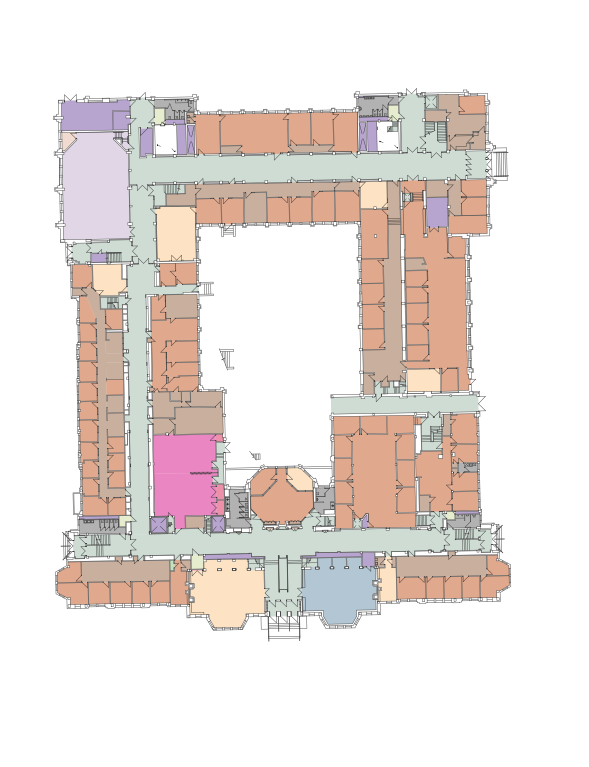

In [78]:
# color rooms by their room types such as office, confernce room, and corridors.
ax = default_ax()
rooms.plot(ax=ax, linewidth=0.0, column='rmtyp_descr50', cmap='Accent')
graphics.plot(ax=ax, linewidth=0.3, color='k')
plt.show()

#### Color by department
Unfortunately, this floor is occupied by only one department.

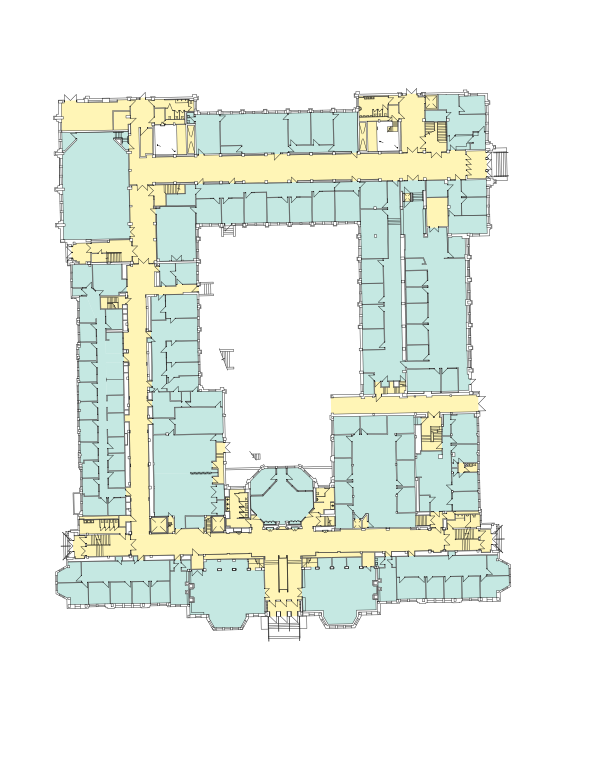

In [91]:
# color rooms by their department
ax2 = default_ax()
rooms.plot(ax=ax2, linewidth=0.0, column='dept_descr', cmap='Set3_r')
graphics.plot(ax=ax2, linewidth=0.3, color='k')
plt.show()

### Let's create nodes at the centroid of each room

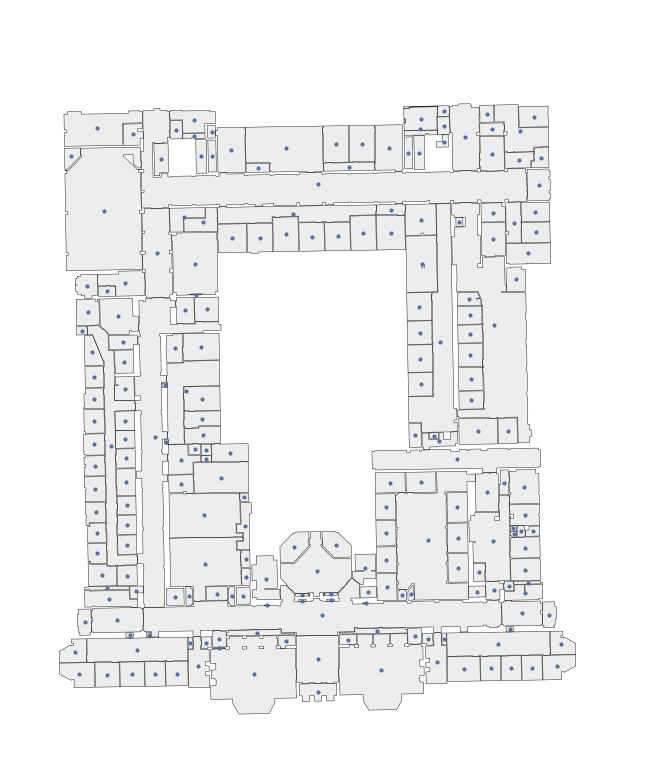

In [96]:
nodes = rooms.geometry.centroid

# plot the nodes over room polygons
ax = default_ax()
rooms.plot(ax=ax, linewidth=0.3, color='#DDDDDD')
nodes.plot(ax=ax, markersize=3, color='b')
plt.show()

### Create edges

Room polygons touch each other if the rooms are connected directly or through doors. If there is a wall between two rooms, there should be a gap between the room polygons. We will set a threshold judging 'touch' without connecting rooms separated by a wall.

In [141]:
def room_edges(df, threshold=0.02):
    # dictionary for edge geometry
    lines = {'geometry':[], 'from':[], 'to':[]}

    for index1, room1 in df.iterrows():
        for index2, room2 in df.iterrows():
            if room1.geometry.buffer(threshold).intersects(room2.geometry.buffer(threshold)) \
                and index1 > index2:
                lines["from"].append(index1)
                lines["to"].append(index2)
                lines["geometry"].append(LineString([room1.geometry.centroid, room2.geometry.centroid]))
    return gpd.GeoDataFrame(lines)
# geodataframe for edges
edges = room_edges(rooms)

### Let's see how rooms are connected

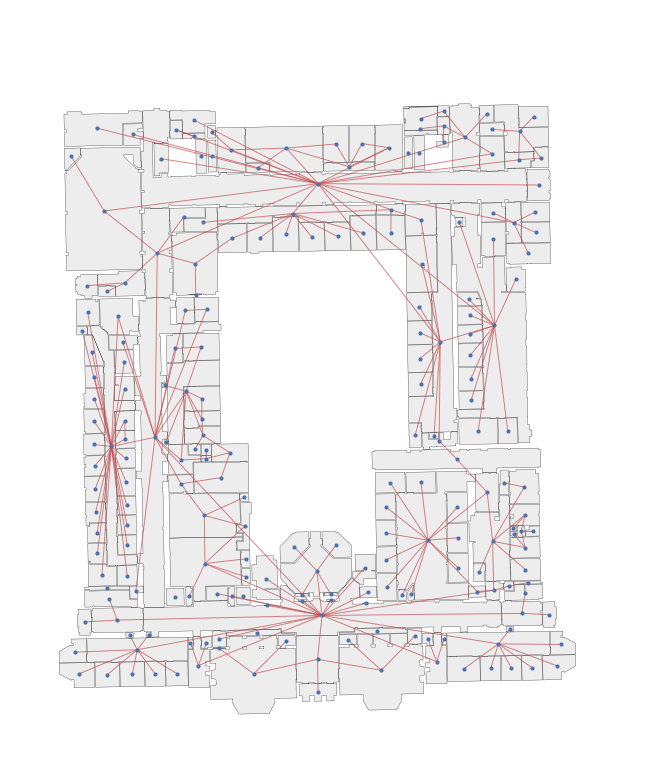

In [112]:
ax = default_ax()
rooms.plot(ax=ax, linewidth=0.2, color='#DDDDDD')
edges.plot(ax=ax, linewidth=0.7, color='r', alpha=0.7)
rooms.geometry.centroid.plot(ax=ax, markersize=3, color='b')
plt.show()

## Let's calculate some network measures for the layout network

In [130]:
room_network = nx.Graph()
for i, edge in edges.iterrows():
    room_network.add_edge(edge["from"], edge["to"])

# calculate closeness and add the values to rooms
closeness = nx.closeness_centrality(room_network)
rooms['closeness'] = pd.Series(closeness)

# calculate betweenness and add the values to rooms
betweenness = nx.betweenness_centrality(room_network)
rooms['betweenness'] = pd.Series(betweenness)

### color rooms by closeness

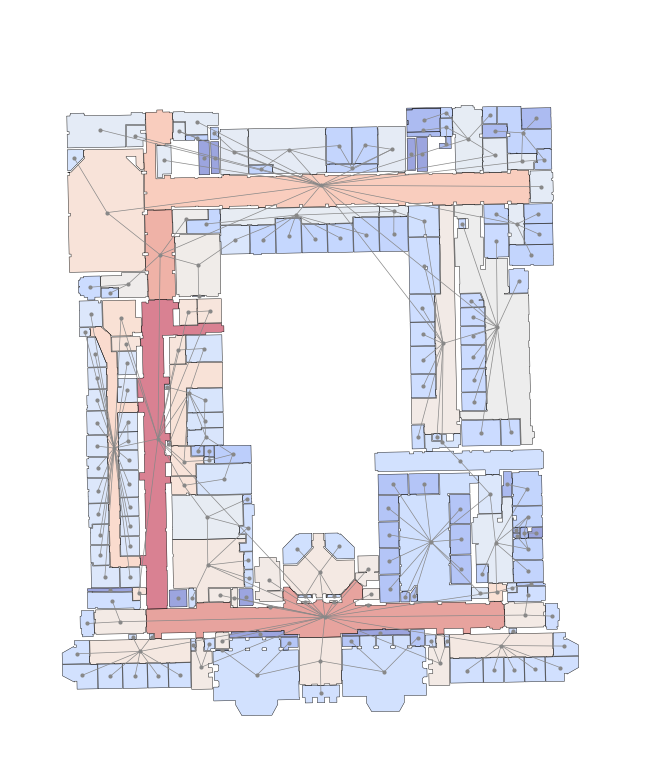

In [131]:
# color rooms by closeness
ax = default_ax()
rooms.plot(ax=ax, linewidth=0.3, column='closeness', cmap='coolwarm')
edges.plot(ax=ax, linewidth=0.5, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=3, color='#888888')
plt.show()

#### Distribution of closeness centrality

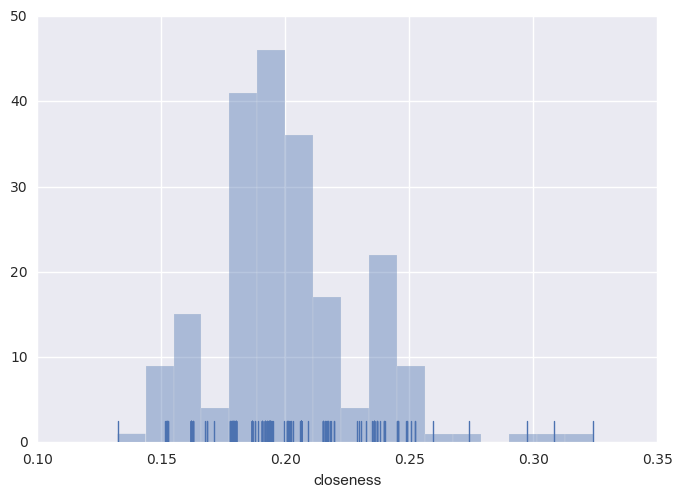

In [121]:
import seaborn as sns
sns.set(color_codes=True)
clo = rooms["closeness"][rooms["closeness"].notnull()]
sns.distplot(clo, kde=False, rug=True);
sns.plt.show()

## Identify communities, or naturally-grouped rooms in the floor

In [133]:
# find community structure in room network using Girvan-Newman algorithm
comp = nx.girvan_newman(room_network)
k = 6  ## number of communities

community = dict() # community labels

# get community when k=6
import itertools
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
comm_structure = None
for communities in limited:
    comm_structure = (list(c for c in communities))

for cid, comm in enumerate(comm_structure):
    for node in comm:
        community[node] = cid

# add a column to dataframe
rooms['community'] = pd.Series(community)

### color rooms by community

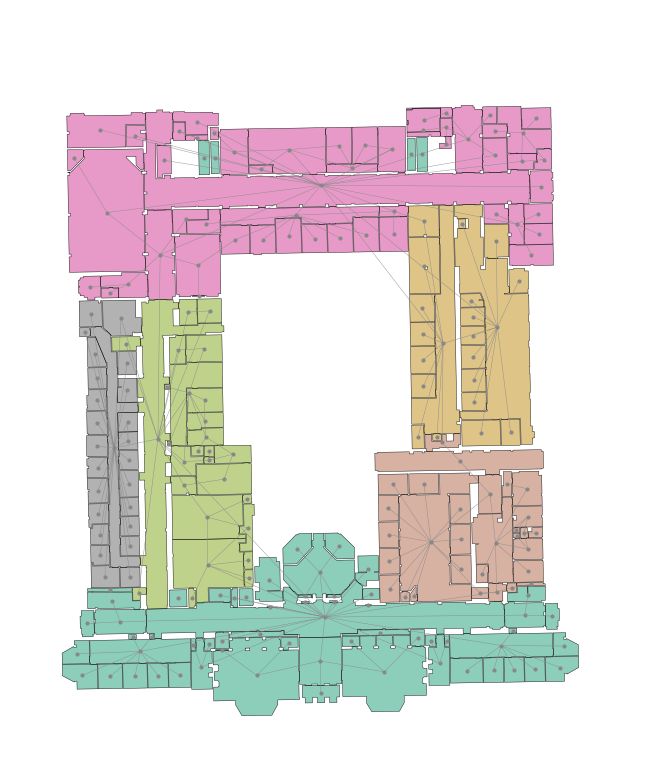

In [135]:
ax = default_ax()
rooms.plot(ax=ax, linewidth=0.3, column='community', cmap='Dark2')
edges.plot(ax=ax, linewidth=0.3, color='#888888')
rooms.geometry.centroid.plot(ax=ax, markersize=3, color='#888888')
plt.show()

### Closeness by room type

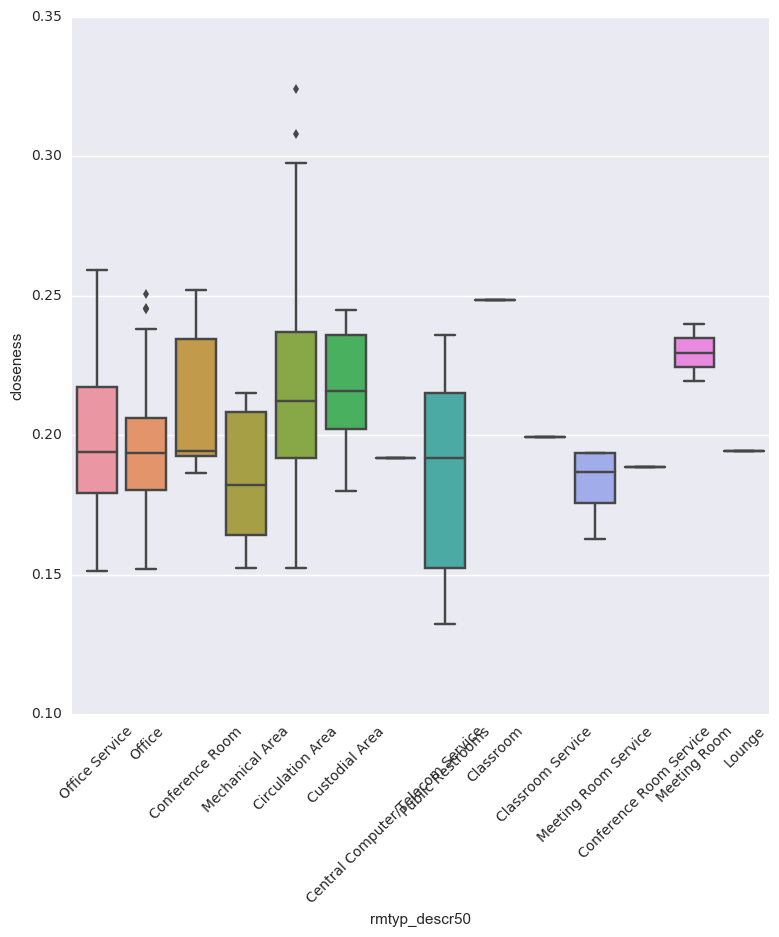

In [138]:
ax = sns.boxplot(x="rmtyp_descr50", y="closeness", data=rooms)
plt.xticks(rotation=45)
sns.plt.show()

### Closeness by region

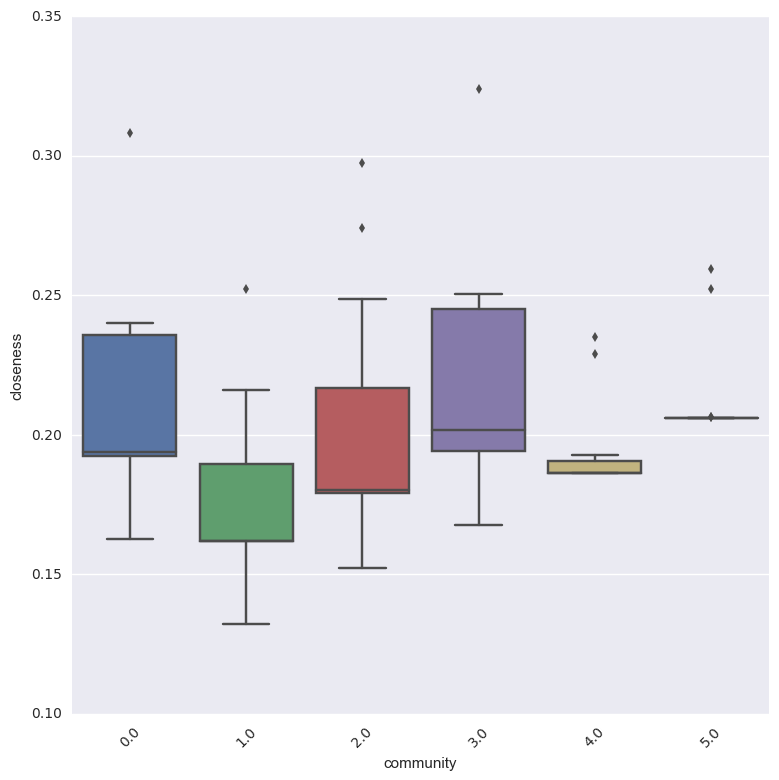

In [139]:
ax = sns.boxplot(x="community", y="closeness", data=rooms)
plt.xticks(rotation=45)
sns.plt.show()